# Image Processing and Computer Vision Project

In [523]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN

## Prove A

In [3]:
img_scene = cv2.imread('scenes/e3.png', cv2.IMREAD_COLOR) # sceneImage BGR
img_prod = cv2.imread('models/11.jpg', cv2.IMREAD_COLOR) # prodImage BGR
#img_scene_rgb = cv2.cvtColor(img_scene, cv2.COLOR_BGR2RGB)

In [4]:
img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)

In [5]:
# Detecting keypoints and computing the descriptors for each keypoints in the product image
sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)

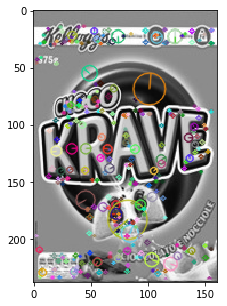

In [6]:
plt.figure(figsize=(5,5))
img_visualization = cv2.drawKeypoints(img_prod_gr,kp_p,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization, cmap='gray', vmin=0, vmax=255)
plt.show()

In [7]:
img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

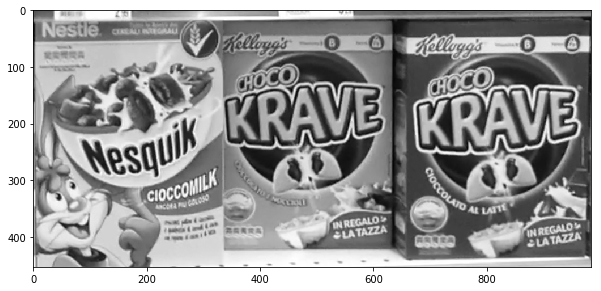

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img_scene_gr, cmap='gray')

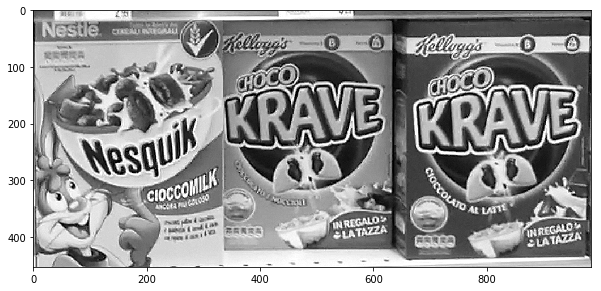

In [9]:
sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])
img_scene_pre = cv2.filter2D(img_scene_gr,-1,sharpen_kernel)
img_scene_pre = np.abs(img_scene_pre)
plt.figure(figsize=(10,10))
plt.imshow(img_scene_pre, cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
# Detecting keypoints and computing the descriptors for each keypoints in the scene image
sift = cv2.xfeatures2d.SIFT_create()
kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)

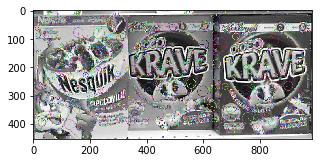

In [11]:
plt.figure(figsize=(5,5))
img_visualization = cv2.drawKeypoints(img_scene_pre,kp_s,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization, cmap='gray', vmin=0, vmax=255)
plt.show()

In [12]:
# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_p,des_s,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

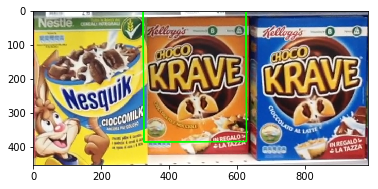

In [16]:
# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = img_prod_gr.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Calculate the bounding box
    x, y, w, h = cv2.boundingRect(dst)
    
    # Drawing bounding box
    final_img = cv2.polylines(img_scene,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
    final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
    plt.imshow(final_img_rgb)
    plt.show()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [19]:
len(good)

88

In [18]:
dst

array([[[323.45572 , -11.05797 ]],

       [[325.35214 , 384.07684 ]],

       [[627.91547 , 383.1545  ]],

       [[626.50745 , -11.675833]]], dtype=float32)

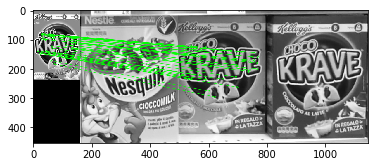

In [126]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img_prod_gr,kp_p,img_scene_gr,kp_s,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

## Prove B

In [393]:
img_scene = cv2.imread('scenes/m2.png', cv2.IMREAD_COLOR) # sceneImage BGR
img_prod = cv2.imread('models/25.jpg', cv2.IMREAD_COLOR) # prodImage BGR
img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

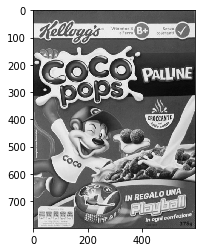

In [394]:
#plt.figure(figsize=(10,10))
plt.imshow(img_prod_gr, cmap='gray')

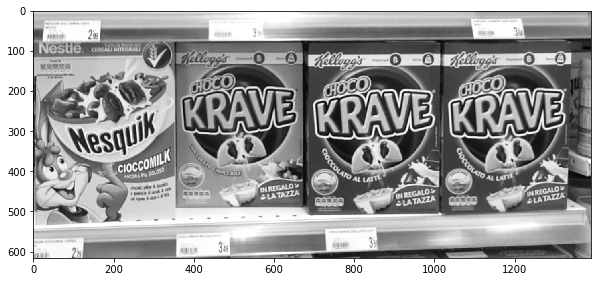

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(img_scene_gr, cmap='gray')

In [395]:
# Detecting keypoints and computing the descriptors for each keypoints in the product image
sift = cv2.xfeatures2d.SIFT_create()
kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)

# Compute the barycenter for the GHT
x = np.mean([kp.pt[0] for kp in kp_p])
y = np.mean([kp.pt[1] for kp in kp_p])
barycen_p = [x,y]

In [396]:
barycen_p

[321.8635759276036, 501.2949750660364]

In [326]:
sharpen_kernel = np.array([
            [0,-1,0],
            [-1,5,-1],
            [0,-1,0]])
img_scene_pre = cv2.filter2D(img_scene_gr,-1,sharpen_kernel)
img_scene_pre = np.abs(img_scene_pre)

# Detecting keypoints and computing the descriptors for each keypoints in the scene image
sift = cv2.xfeatures2d.SIFT_create()
kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)

In [397]:
# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_p,des_s,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [398]:
len(good)

41

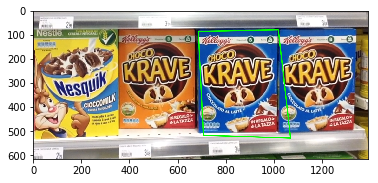

In [399]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = img_prod_gr.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Calculate the bounding box
    x, y, w, h = cv2.boundingRect(dst)
    
    # Drawing bounding box
    final_img = img_scene.copy()
    final_img = cv2.polylines(final_img,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
    final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
    plt.imshow(final_img_rgb)
    plt.show()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

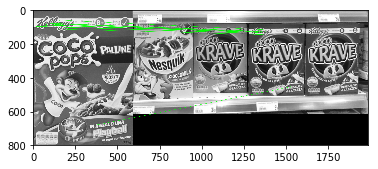

In [400]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img_prod_gr,kp_p,img_scene_gr,kp_s,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

In [194]:
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))


In [195]:
aa_matrix.shape

(123, 278)

In [498]:
# Online phase of the GHT algorithm
aa_quant_fact = 5
aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
dict_matches = {}

for m in good:
    # Retrieve only good matches
    kp_p_good = kp_p[m.queryIdx]
    kp_s_good = kp_s[m.trainIdx]

    # Compute the vector that connects each keypoint to the barycenter
    vec = np.subtract(barycen_p, kp_p_good.pt)

    # Scale the vector 
    vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

    # Rotate the vector
    rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
    rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
    vec_scaled_rot = rot_matrix.dot(vec_scaled)
    
    # Calculate barycenter
    bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
    bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)
    
    bar = (bar_x, bar_y)
    if bar in dict_matches.keys():
        dict_matches[bar].append(m)
    else:
        dict_matches[bar] = [m]
                
    
    # Cast a vote
    if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
        aa_matrix[bar[1], bar[0]] += 1

In [153]:
aaMatches

{(288, -43): [<DMatch 0x7f710100bfd0>],
 (291, 309): [<DMatch 0x7f710100bf10>],
 (304, 351): [<DMatch 0x7f71010035d0>],
 (310, 318): [<DMatch 0x7f7101003410>],
 (317, -74): [<DMatch 0x7f71010034d0>],
 (331, -29): [<DMatch 0x7f71010036d0>],
 (333, 341): [<DMatch 0x7f7101003950>],
 (334, 41): [<DMatch 0x7f7101003f50>],
 (337, 114): [<DMatch 0x7f7101003a50>],
 (338, 152): [<DMatch 0x7f71010039d0>],
 (339, -37): [<DMatch 0x7f7101003a10>],
 (344, 136): [<DMatch 0x7f7101003b10>],
 (347, 247): [<DMatch 0x7f7101003d10>],
 (356, -25): [<DMatch 0x7f7101003d50>],
 (377, 173): [<DMatch 0x7f7101006450>],
 (424, 97): [<DMatch 0x7f7101006b90>],
 (447, -89): [<DMatch 0x7f7101005150>],
 (467, -86): [<DMatch 0x7f7101005410>],
 (495, 449): [<DMatch 0x7f7101005910>],
 (526, 207): [<DMatch 0x7f7101005e90>],
 (560, 126): [<DMatch 0x7f7100fff690>, <DMatch 0x7f7100fff6d0>],
 (567, 142): [<DMatch 0x7f7100fff8d0>],
 (576, 417): [<DMatch 0x7f7100fffa50>],
 (590, 594): [<DMatch 0x7f71010069d0>],
 (620, 373): [<DM

In [270]:
aa_matrix.shape

(123, 278)

In [318]:
np.max(aa_matrix)

3.0

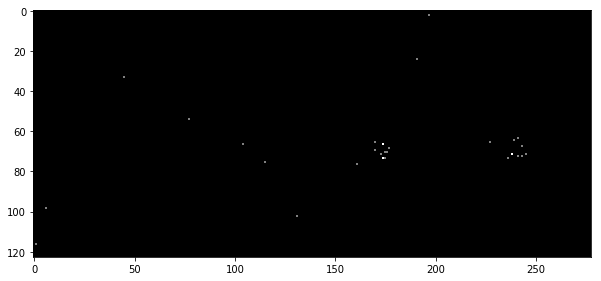

In [500]:
plt.figure(figsize=(10,10))
plt.imshow(aa_matrix, cmap='gray')

In [422]:
non_null = aa_matrix>0

In [508]:
non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)

In [509]:
non_null.shape

(28, 2)

In [518]:
from sklearn.cluster import DBSCAN
y = DBSCAN(eps=10, min_samples=5).fit_predict(non_null)

In [519]:
y

array([-1, -1, -1, -1,  0,  0,  1, -1, -1,  1,  0,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  1,  1,  0, -1, -1, -1, -1, -1])

In [520]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

In [521]:
cluster_labels_all = np.unique(y)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
cl = []
for i in cluster_labels:
    cl.append(non_null[y==i].tolist())

In [516]:
cl

[[[241, 63],
  [239, 64],
  [243, 67],
  [238, 71],
  [245, 71],
  [241, 72],
  [243, 72],
  [236, 73]],
 [[170, 65],
  [174, 66],
  [177, 68],
  [170, 69],
  [175, 70],
  [176, 70],
  [173, 71],
  [174, 73],
  [175, 73]]]

In [522]:
for instance in cl:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[tuple(pt)]
    print(len(instanceMatches))
    if len(instanceMatches) > 30:
        prova = instanceMatches

9
11


In [412]:
maxDist = 15
clusters = []

for y in range(aa_matrix.shape[0]):
    for x in range(aa_matrix.shape[1]):
        if aa_matrix[y,x] > 0:
            poss_cl = []
            for cl_id, cl in enumerate(clusters):
                for pt in cl:
                    dist = math.sqrt((x-pt[0])**2 + (y-pt[1])**2)
                    if dist <= maxDist:
                        poss_cl.append(cl_id)
                        break

            if len(poss_cl) == 0:
                # Create a new cluster
                clusters.append([(x,y)]) 
            else:
                # Combine clusters
                for cl in poss_cl[1:][::-1]:
                    clusters[poss_cl[0]] += clusters[cl]
                    del clusters[cl]

                clusters[poss_cl[0]].append((x,y))


In [410]:
len(clusters)

10

In [492]:
clusters

[[(197, 2)],
 [(191, 24)],
 [(45, 33)],
 [(77, 54)],
 [(241, 63),
  (239, 64),
  (227, 65),
  (243, 67),
  (238, 71),
  (245, 71),
  (241, 72),
  (243, 72),
  (236, 73)],
 [(170, 65),
  (174, 66),
  (177, 68),
  (170, 69),
  (175, 70),
  (176, 70),
  (173, 71),
  (174, 73),
  (175, 73),
  (161, 76)],
 [(104, 66), (115, 75)],
 [(6, 98)],
 [(131, 102)],
 [(1, 116)]]

In [470]:
for instance in clusters:
    instanceMatches = []
    for pt in instance:
        instanceMatches += dict_matches[pt]
    print(len(instanceMatches))
    if len(instanceMatches) > 30:
        prova = instanceMatches

1
1
1
1
10
12
2
1
1
1


In [208]:
prova

[<DMatch 0x7f7101006bd0>,
 <DMatch 0x7f7101006890>,
 <DMatch 0x7f7101003850>,
 <DMatch 0x7f7101006210>,
 <DMatch 0x7f71010061d0>,
 <DMatch 0x7f7101006250>,
 <DMatch 0x7f7101003810>,
 <DMatch 0x7f7101003e10>,
 <DMatch 0x7f7101006c50>,
 <DMatch 0x7f7101000710>,
 <DMatch 0x7f7101000b10>,
 <DMatch 0x7f71010050d0>,
 <DMatch 0x7f71010052d0>,
 <DMatch 0x7f7101000a50>,
 <DMatch 0x7f7101003b90>,
 <DMatch 0x7f7101001050>,
 <DMatch 0x7f7100fffe90>,
 <DMatch 0x7f7101006a10>,
 <DMatch 0x7f7100ffffd0>,
 <DMatch 0x7f7101005390>]

In [164]:
len(instanceMatches)

1

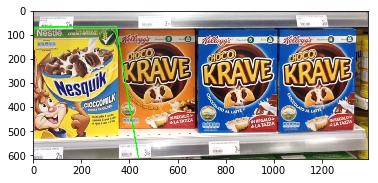

In [392]:
src_pts = np.float32([ kp_p[m.queryIdx].pt for m in prova ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in prova ]).reshape(-1,1,2)

# Calculating homography based on correspondences
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Matches mask for visualization of only matches used by RANSAC
matchesMask = mask.ravel().tolist()

# Apply homography to project corners of the query image into the image
h,w = img_prod_gr.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# Calculate the bounding box
x, y, w, h = cv2.boundingRect(dst)

# Drawing bounding box
final_img = img_scene.copy()
final_img = cv2.polylines(final_img,np.int32([dst]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()